# Cryptocurrency passive stategy

This document shows a python script which can be used to implement a simple market-weighted passive strategy for trading crypto currencies. The script calls data from coinmarketcap.com API into a pandas DataFrame. We then display Top 10 currencies and use this detail to make BUY/SELL reccomendations to re-balance a hypothetical portfolio.

In [101]:
# Import the packages we'll use for our analysis

import pandas as pd
import datetime
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

# Use line magic function to enable matplotlib to work interactively with iPython

%matplotlib inline
%pylab inline

#Set style
#plt.style.use("seaborn-whitegrid")
style.use('fivethirtyeight')
#sns.set_style("whitegrid")
pylab.rcParams["figure.figsize"] = (8,6)
#sns.palplot(sns.color_palette("Blues_d"))

Populating the interactive namespace from numpy and matplotlib


In [102]:
class cryptoMarket():
    
    def __init__(self):
        self.url = url
    
    def load_data(self):
        json = requests.get(url).json()
        dfCrypto = pd.DataFrame(json)
        dfCrypto["market_cap_usd"] = pd.to_numeric(dfCrypto["market_cap_usd"])
        return dfCrypto
    
    def market_summary(self):
        dfSummary = self.load_data()
        count = dfSummary["market_cap_usd"].count()
        market_cap = pd.to_numeric(dfSummary["market_cap_usd"]).sum()
        today = datetime.datetime.today().date()
        print (f"The total Market Cap today {today} is {market_cap}")
        print (f"The total count of currencies today {today} is {count}")
    
    def top_10(self):
        dfCrypto = self.load_data()
        dfTop9 = dfCrypto[["id","market_cap_usd"]][:10]
        dfRemainder = dfCrypto["market_cap_usd"][10:].sum()
        dfRemainder = pd.DataFrame([["other",dfRemainder]], columns=["id","market_cap_usd"])
        dfTop10 = dfTop9.append(dfRemainder, ignore_index = True).set_index("id")
        dfTop10["total_usd"] =  dfCrypto["market_cap_usd"].sum()
        dfTop10["pct_of_market"] = (dfTop10["market_cap_usd"] / dfTop10["total_usd"]) * 100
        return dfTop10
    
    def passive_strategy(self):
        dfCrypto = self.top_10()
        allocation =  [100] * 10
        ids = df_mc.index[:10]
        portfolio = pd.DataFrame({"start_alloc":allocation, "id":ids}).set_index("id")
        portfolio = portfolio.join(dfCrypto["pct_of_market"])
        portfolio["AUM"] = port["start_alloc"].sum()
        portfolio["target_alloc"] = (port["pct_of_market"] / 100) * port["AUM"]
        portfolio["adjustment"] = portfolio["target_alloc"] - portfolio["start_alloc"]
        return portfolio
        

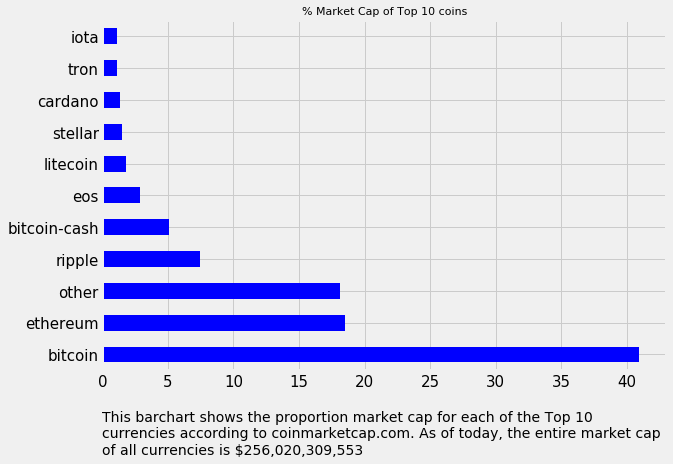

In [103]:
myCrypto = cryptoMarket()
top_10 = myCrypto.top_10()
top_10 = top_10.sort_values("pct_of_market", ascending = False)

ax = top_10["pct_of_market"].plot.barh(grid = True, fontsize = 15, figsize  = (9,6), stacked="True", colormap='winter')
ax.set(ylabel = "")
ax.set_title("% Market Cap of Top 10 coins",fontsize = 11)
plt.annotate(footer, (0,0), (0, -40), xycoords='axes fraction', textcoords='offset points', va='top')
plt.show()

In [122]:
passive = myCrypto.passive_strategy()

for index, row in passive["adjustment"].iteritems():
    if row > 0:
        print ("BUY ${} of {}".format(str(round(row)), index))
    else:
        print ("SELL ${} of {}".format(str(round(abs(row))), index))


BUY $309 of bitcoin
BUY $85 of ethereum
SELL $25 of ripple
SELL $49 of bitcoin-cash
SELL $71 of eos
SELL $82 of litecoin
SELL $85 of stellar
SELL $86 of cardano
SELL $89 of tron
SELL $89 of iota
